# This notebook shows how to load and analyse GAN generated sequences.
#### GAN generated sequences are provided in ./data/gan/generated_seqs folder.
#### Background sequences are provided in ./data/gan/background_seqs folder.
#### Genomic sequences are provided in ./data/gan folder
#### It consists of:
* Reading GAN generated, genomic, and background sequences.
* Scoring generated sequences with the DeepMEL model.
* Visualising prediction scores on gan generated sequences at different training steps.
* Comparing GC content of GAN generated and background sequences.
* Visualising the results and contribution scores.
#### Intermediate files are saved to ./data/gan folder
#### Figures are saved to ./figures/gan folder


### General imports


In [ ]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


### Loading DeepFlyBrain data to be used for the initialization of shap.DeepExplainer


In [ ]:
print('Loading data...')
f = open('./data/deepflybrain/DeepFlyBrain_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

### Loading the model and initializing shap.DeepExplainer


In [ ]:
print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "DeepFlyBrain"
model_json_file = "models/deepflybrain/model.json"
model_hdf5_file = "models/deepflybrain/model_epoch_83.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), nonAugmented_data_dict["train_data"][rn])

In [ ]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### Reading GAN generated, genomic, and background sequences and calculating prediction scores

In [5]:
# data_dict = {}
# data_dict["KCgan"] = {}
# for iter_ in range(0,261000,10000):
#     data_dict["KCgan"][iter_] = {}
#     data_dict["KCgan"][iter_]["seq"], data_dict["KCgan"][iter_]["ids"]= utils.prepare_data("data/gan/generated_seqs/generated_6144_iter_"+str(iter_)+".fa")
#     data_dict["KCgan"][iter_]["pred"] = model_dict["DeepFlyBrain"].predict([data_dict["KCgan"][iter_]["seq"],data_dict["KCgan"][iter_]["seq"][:,::-1,::-1]])
        
# data_dict["original"] = {}
# data_dict["original"]["seq"], data_dict["original"]["ids"] =  utils.prepare_data("data/gan/Genomic_KC_regions.fa")
# data_dict["original"]["pred"] = model_dict["DeepFlyBrain"].predict([data_dict["original"]["seq"],data_dict["original"]["seq"][:,::-1,::-1]])

# data_dict["bg"] = {}
# for order in [0,1,2,3,4]:
#     data_dict["bg"][order] = {}
#     data_dict["bg"][order]["seq"], data_dict["bg"][order]["ids"] =  utils.prepare_data("data/gan/background_seqs/Genomic_KC_regions.bg_o"+str(order)+".fa")
#     data_dict["bg"][order]["pred"] = model_dict["DeepFlyBrain"].predict([data_dict["bg"][order]["seq"],data_dict["bg"][order]["seq"][:,::-1,::-1]])

# import pickle 
# with open('data/gan/GAN_data_dict.pkl', 'wb') as f:
#     pickle.dump(data_dict, f)

import pickle 
with open('data/gan/GAN_data_dict.pkl', 'rb') as f:
    data_dict = pickle.load(f)

### Plotting prediction scores of the GAN generated sequences at different iterations as well as background sequences

6144


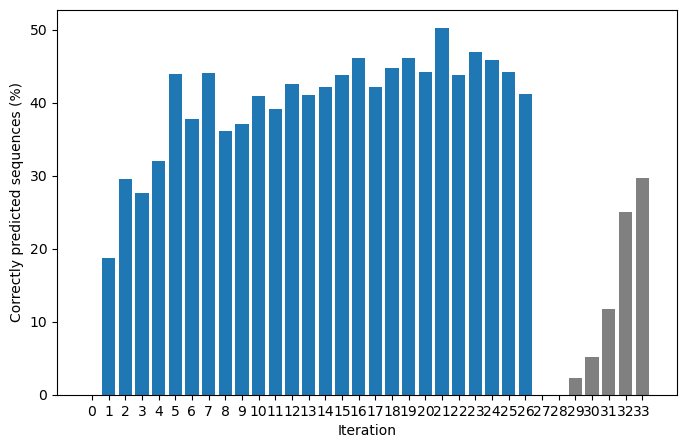

In [6]:
plt.figure(figsize=(8,5))
print(len(data_dict["bg"][0]["pred"]))
th = 0.25
for k,i in enumerate(range(0,261000,10000)):
    plt.bar(k,np.sum(np.logical_or(data_dict["KCgan"][i]["pred"][:,20]>th,
              np.logical_or(data_dict["KCgan"][i]["pred"][:,34]>th,
                            data_dict["KCgan"][i]["pred"][:,76]>th)))/6144*100,color="C0")


for k,i in enumerate(range(5)):
    plt.bar(k+29,np.sum(np.logical_or(data_dict["bg"][i]["pred"][:,20]>0.25,
              np.logical_or(data_dict["bg"][i]["pred"][:,34]>0.25,
                            data_dict["bg"][i]["pred"][:,76]>0.25)))/6144*100,color="gray")

_ = plt.xticks(range(34),range(34))

plt.xlabel("Iteration")
plt.ylabel("Correctly predicted sequences (%)")

plt.savefig("figures/gan/prediction_percentage_bar.pdf",transparent=True)

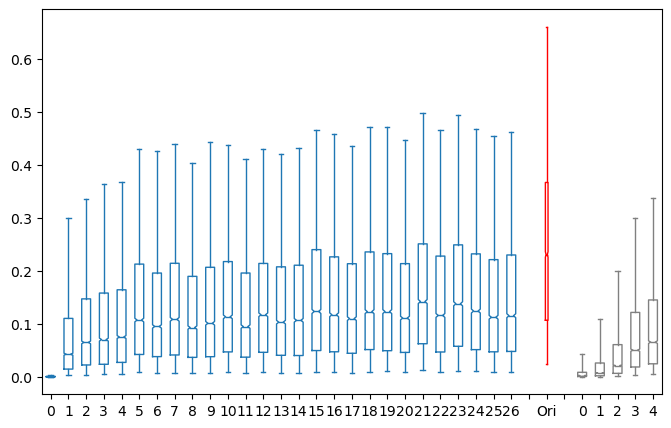

In [7]:
plt.figure(figsize=(8,5))
c = "C0"
_ = plt.boxplot([data_dict["KCgan"][key]["pred"][:,34] for key in data_dict["KCgan"]],notch=True,showfliers=False, whis=[5,95],
                positions=list(range(0,27)),
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                )
c = 'red'
_ = plt.boxplot(data_dict["original"]["pred"][:,34],notch=True,showfliers=False, whis=[5,95],
                positions=list(range(28,29)),
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                )
c = 'grey'
_ = plt.boxplot([data_dict["bg"][key]["pred"][:,34] for key in data_dict["bg"]],notch=True,showfliers=False, whis=[5,95],
                positions=list(range(30,35)),
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                )
_ = plt.xticks(range(35),list(range(0,27))+["","Ori",""]+list(range(5)))
plt.savefig("figures/gan/prediction_distribution_bar.pdf",transparent=True)

### Smoothed plotting of GC-content comparison of Genomic, GAN generated and background sequences

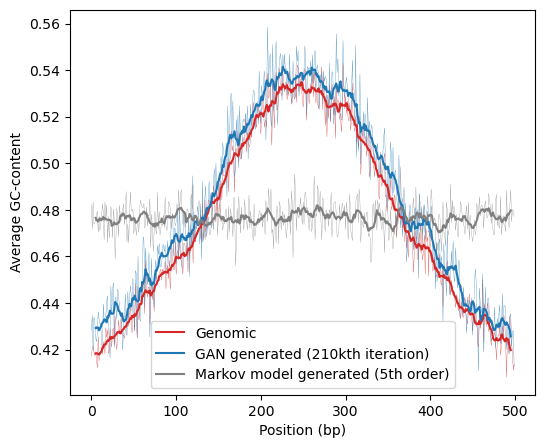

In [8]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

plt.figure(figsize=(6,5))
plt.plot((np.mean(data_dict["original"]["seq"][:,:,1] + data_dict["original"]["seq"][:,:,2],axis=0)),color="C3",linewidth=0.2)
plt.plot((np.mean(data_dict["KCgan"][210000]["seq"][:,:,1] + data_dict["KCgan"][210000]["seq"][:,:,2],axis=0)),color="C0",linewidth=0.2)
plt.plot((np.mean(data_dict["bg"][4]["seq"][:,:,1] + data_dict["bg"][4]["seq"][:,:,2],axis=0)),color="gray",linewidth=0.2)

smt_val = 10
plt.plot(range(5,496),smooth(np.mean(data_dict["original"]["seq"][:,:,1] + data_dict["original"]["seq"][:,:,2],axis=0),smt_val),label="Genomic",color="C3")
plt.plot(range(5,496),smooth(np.mean(data_dict["KCgan"][210000]["seq"][:,:,1] + data_dict["KCgan"][210000]["seq"][:,:,2],axis=0),smt_val),label="GAN generated (210kth iteration)",color="C0")
plt.plot(range(5,496),smooth(np.mean(data_dict["bg"][4]["seq"][:,:,1] + data_dict["bg"][4]["seq"][:,:,2],axis=0),smt_val),label="Markov model generated (5th order)",color="gray")
plt.legend()

plt.xlabel("Position (bp)")
plt.ylabel("Average GC-content")

plt.savefig("figures/gan/GC_content_Genomic_Gan_Background.pdf",transparent=True)

### Plotting nucleotide contribution scores and in silico saturation mutagenesis values on the GAN-generated sequences

<Figure size 4300x1000 with 0 Axes>

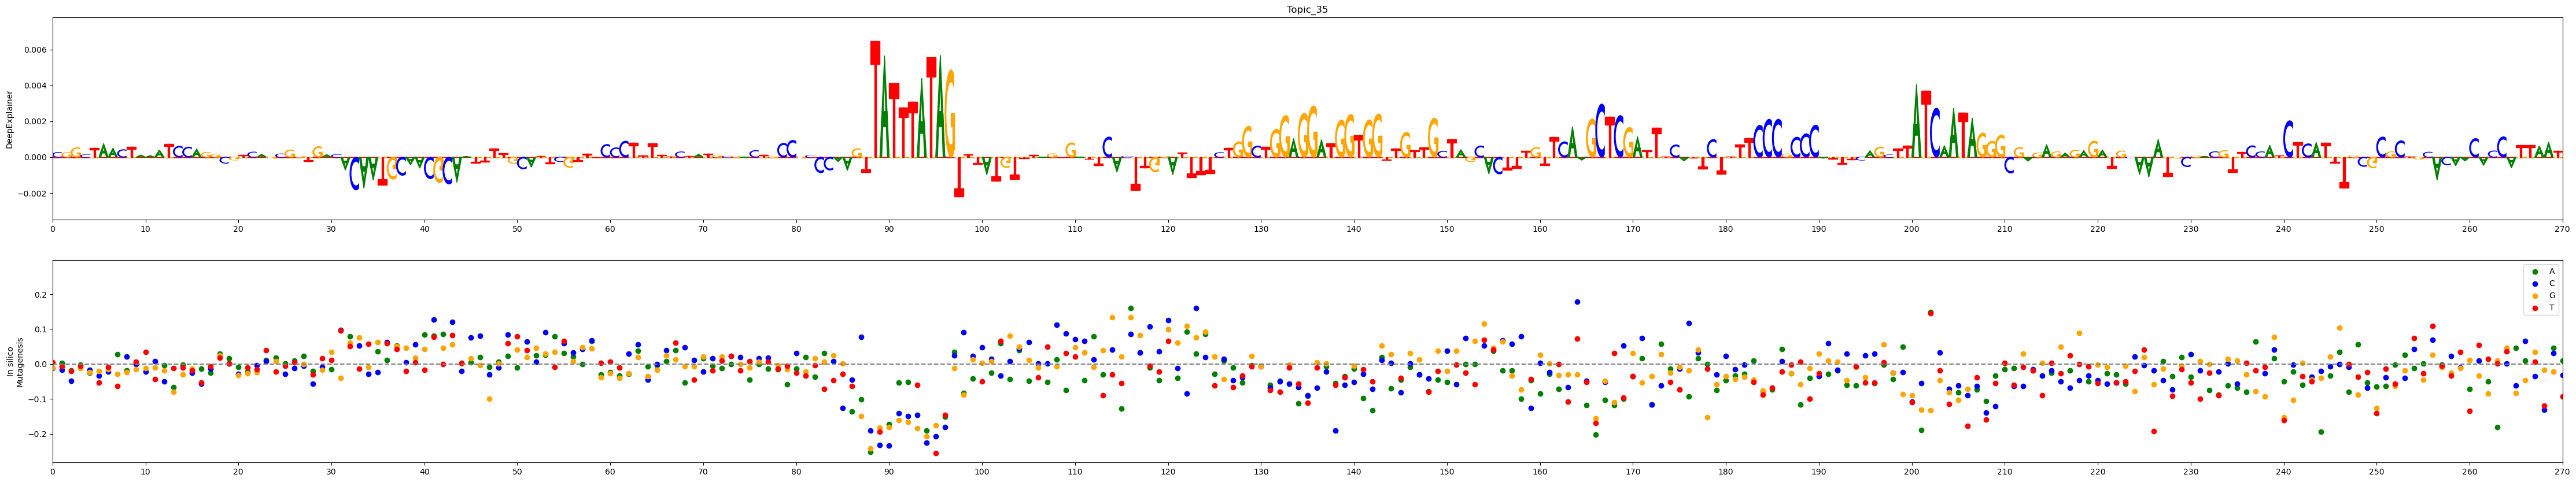

In [9]:
# ["1274_KCpred_210000",
#  "944_KCpred_210000",
#  "1827_KCpred_210000",
#  "3371_KCpred_210000",
#  "3473_KCpred_210000"]

region = '944_KCpred_210000'  
ntrack = 2
fig = plt.figure(figsize=(43,ntrack*5))
seq_onehot = np.copy(data_dict["KCgan"][210000]["seq"][np.array(data_dict["KCgan"][210000]["ids"])==region])

st = 0
end = 270

ntrack = 2
fig = plt.figure(figsize=(56,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 35)
ax2 = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 35)

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/gan/944_KCpred_210000_st0_end270_deepexplainer_topic35.pdf",transparent=True)


<Figure size 4300x1000 with 0 Axes>

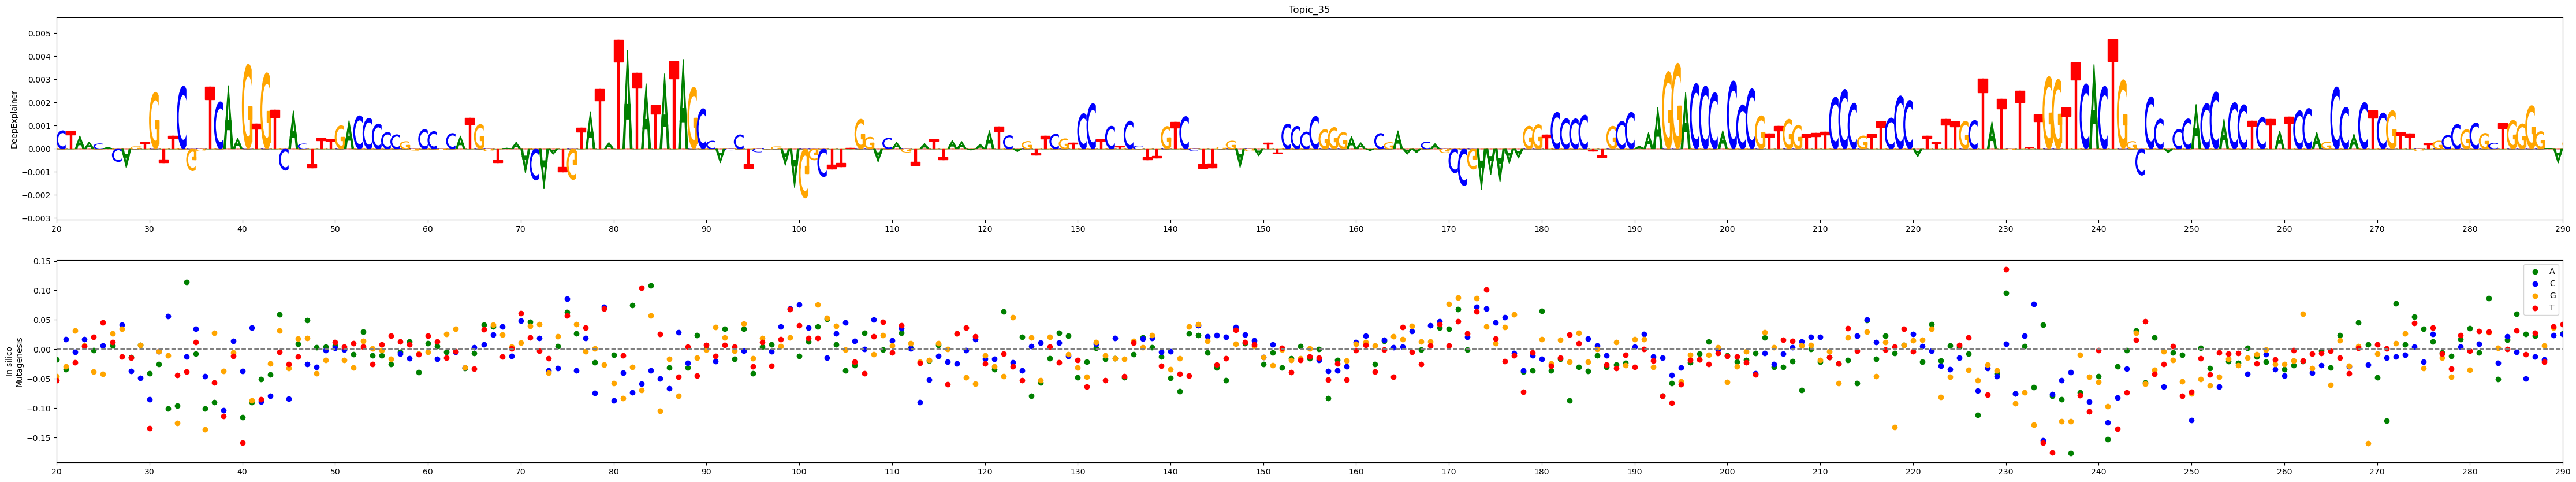

In [10]:
# ["1274_KCpred_210000",
#  "944_KCpred_210000",
#  "1827_KCpred_210000",
#  "3371_KCpred_210000",
#  "3473_KCpred_210000"]

region = '1827_KCpred_210000'  
ntrack = 2
fig = plt.figure(figsize=(43,ntrack*5))
seq_onehot = np.copy(data_dict["KCgan"][210000]["seq"][np.array(data_dict["KCgan"][210000]["ids"])==region])

st = 20
end = 290

ntrack = 2
fig = plt.figure(figsize=(56,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 35)
ax2 = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 35)

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/gan/1827_KCpred_210000_st20_end290_deepexplainer_topic35.pdf",transparent=True)


<Figure size 4300x1000 with 0 Axes>

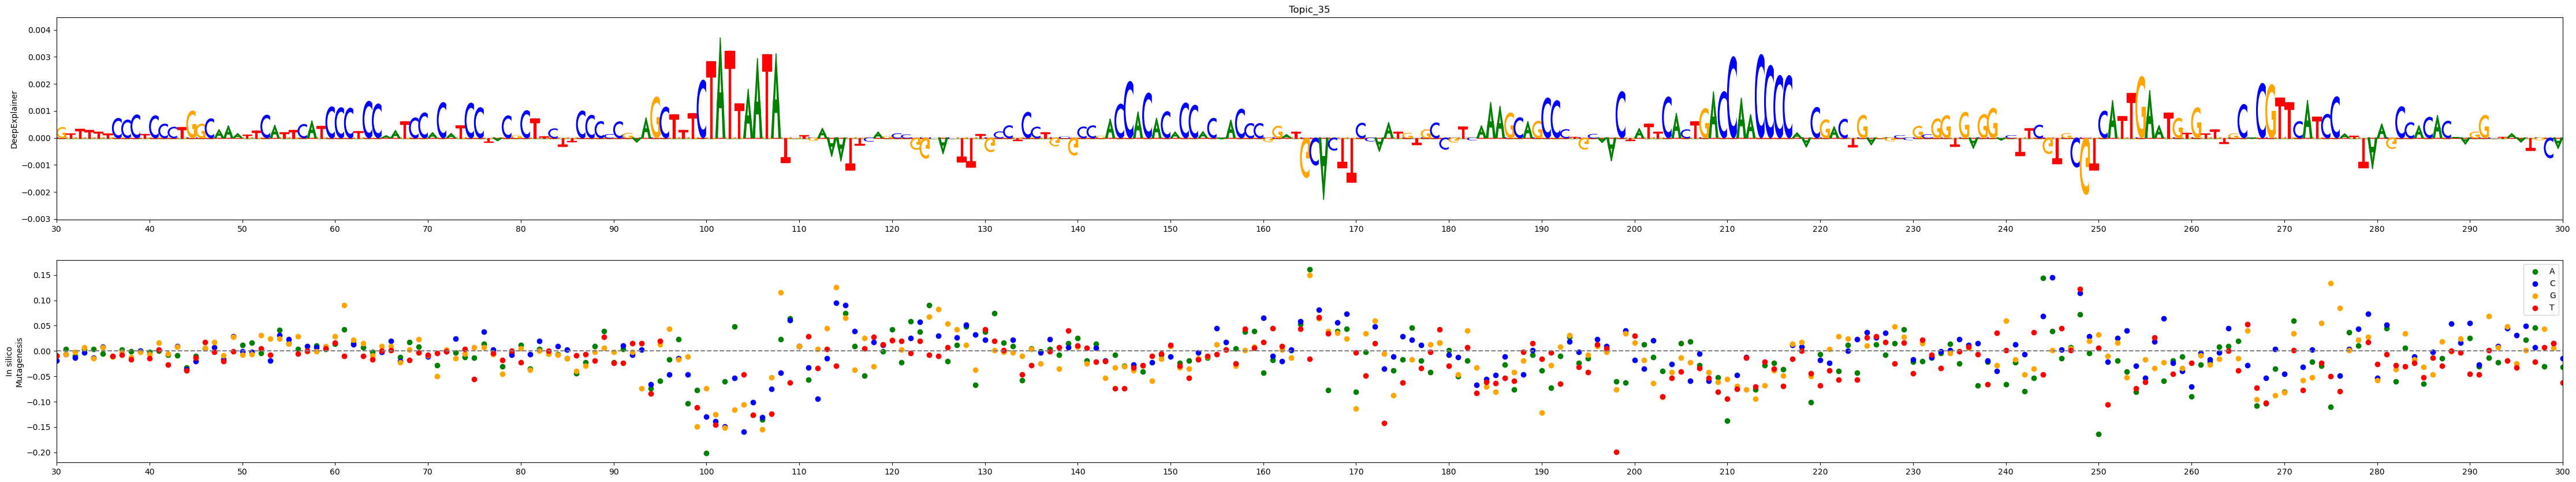

In [11]:
# ["1274_KCpred_210000",
#  "944_KCpred_210000",
#  "1827_KCpred_210000",
#  "3371_KCpred_210000",
#  "3473_KCpred_210000"]

region = '3371_KCpred_210000'  
ntrack = 2
fig = plt.figure(figsize=(43,ntrack*5))
seq_onehot = np.copy(data_dict["KCgan"][210000]["seq"][np.array(data_dict["KCgan"][210000]["ids"])==region])

st = 30
end = 300

ntrack = 2
fig = plt.figure(figsize=(56,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 35)
ax2 = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 35)

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/gan/3371_KCpred_210000_st0_end270_deepexplainer_topic35.pdf",transparent=True)


<Figure size 4300x1000 with 0 Axes>

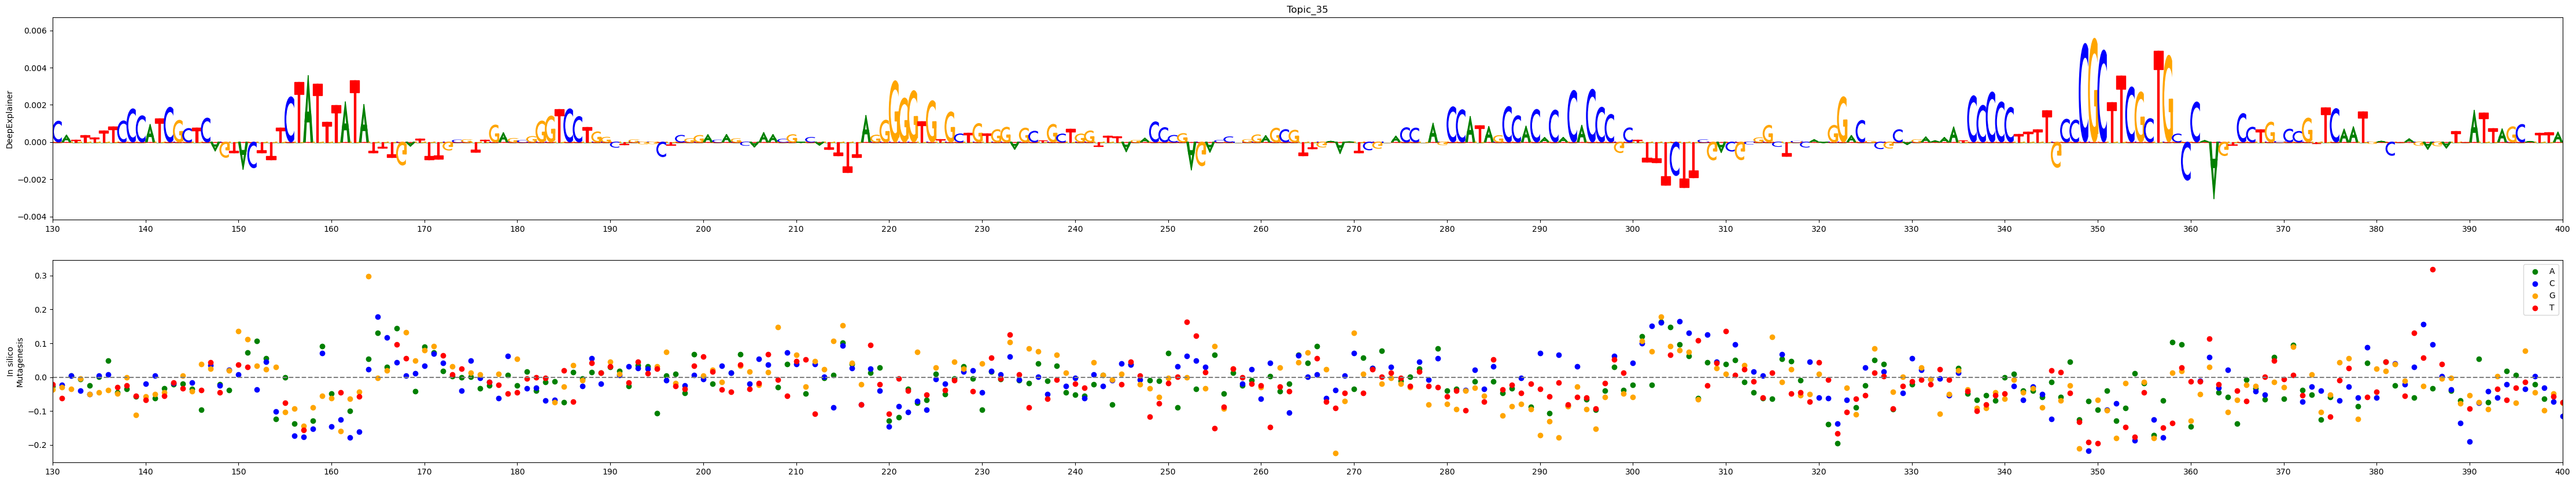

In [12]:
# ["1274_KCpred_210000",
#  "944_KCpred_210000",
#  "1827_KCpred_210000",
#  "3371_KCpred_210000",
#  "3473_KCpred_210000"]

region = '3473_KCpred_210000'  
ntrack = 2
fig = plt.figure(figsize=(43,ntrack*5))
seq_onehot = np.copy(data_dict["KCgan"][210000]["seq"][np.array(data_dict["KCgan"][210000]["ids"])==region])

st = 130
end = 400

ntrack = 2
fig = plt.figure(figsize=(56,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 35)
ax2 = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 35)

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/gan/3473_KCpred_210000_st0_end270_deepexplainer_topic35.pdf",transparent=True)


<Figure size 4300x1000 with 0 Axes>

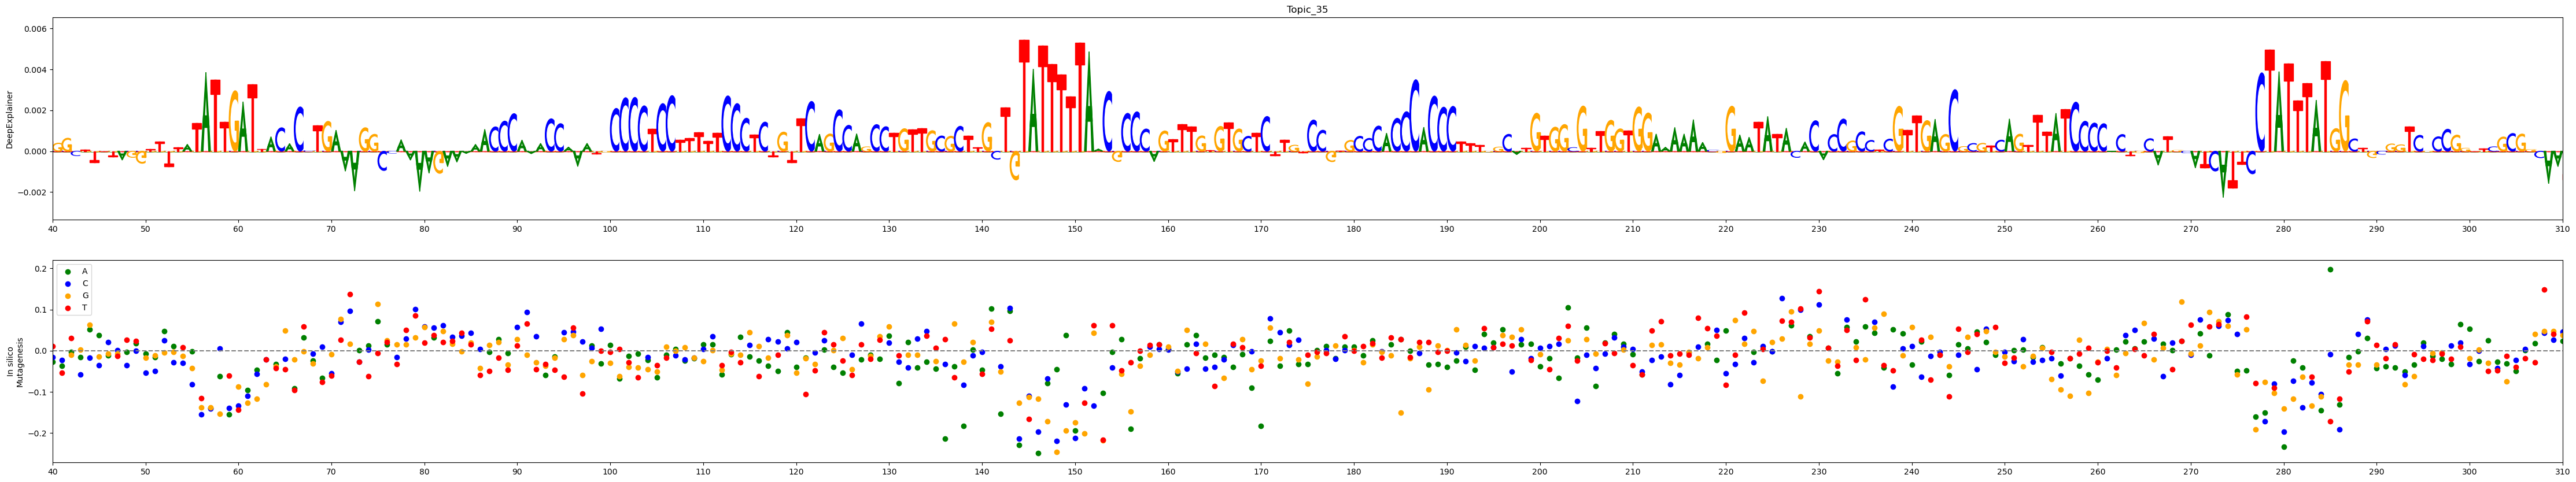

In [13]:
# ["1274_KCpred_210000",
#  "944_KCpred_210000",
#  "1827_KCpred_210000",
#  "3371_KCpred_210000",
#  "3473_KCpred_210000"]

region = '1274_KCpred_210000'  
ntrack = 2
fig = plt.figure(figsize=(43,ntrack*5))
seq_onehot = np.copy(data_dict["KCgan"][210000]["seq"][np.array(data_dict["KCgan"][210000]["ids"])==region])

st = 40
end = 310

ntrack = 2
fig = plt.figure(figsize=(56,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=seq_onehot, class_no = 35)
ax2 = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=seq_onehot, class_no = 35)

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])

plt.savefig("figures/gan/1274_KCpred_210000_st40_end310_deepexplainer_topic35.pdf",transparent=True)
